In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from predictables.util import to_pl_lf
from predictables.univariate import Univariate

# load data
df = load_breast_cancer(as_frame=True).frame
df.columns = [c.replace(" ", "_") for c in df.columns]
df["cv"] = np.random.randint(1, 6, df.shape[0])
df = to_pl_lf(df)

df.head().collect()

mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,radius_error,texture_error,perimeter_error,area_error,smoothness_error,compactness_error,concavity_error,concave_points_error,symmetry_error,fractal_dimension_error,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target,cv
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,i32
17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,0,5
20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902,0,4
19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758,0,5
11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173,0,2
20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575.0,0.1374,0.205,0.4,0.1625,0.2364,0.07678,0,3


In [2]:
df.collect().shape

(569, 32)

### fit each fold to a model

In [3]:
X, y = (
    df.collect().to_pandas().drop(columns="target"),
    df.select("target").collect().to_pandas()["target"],
)
X.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,cv
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,5
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,4
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,5
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3


In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pd.DataFrame(
    pca.transform(X), columns=[f"comp_{i}" for i in range(1, 3)]
).assign(cv=X["cv"])
X_pca

,comp_1,comp_2,cv
0,1160.142186,-293.918296,5
1,1269.122238,15.629752,4
2,995.793505,39.155983,5
3,-407.180613,-67.379945,2
4,930.341164,189.340669,3
...,...,...,...
564,1414.126842,110.222739,2
565,1045.018653,77.057168,4
566,314.501383,47.552808,5
567,1124.858095,34.129148,3


In [5]:
m = Univariate(
    df=pd.concat([X_pca, y], axis=1),
    fold_col="cv",
    feature_col="comp_1",
    target_col="target",
)
m

<Model(df)>

In [6]:
m.coef

-0.007272401955715576

In [7]:
m.results.round(2)

,coef,pvalues,se,lower_ci,upper_ci,acc_train,acc_test,auc_train,auc_test,f1_train,f1_test,precision_train,precision_test,recall_train,recall_test,mcc_train,mcc_test,logloss_train,logloss_test
fold,,,,,,,,,,,,,,,,,,,
1,-0.01,0.0,0.0,-0.01,-0.01,0.89,0.96,0.87,0.95,0.92,0.97,0.88,0.96,0.96,0.99,0.77,0.92,3.83,1.33
2,-0.01,0.0,0.0,-0.01,-0.01,0.91,0.91,0.88,0.90,0.93,0.92,0.89,0.93,0.98,0.92,0.80,0.80,3.35,3.39
3,-0.01,0.0,0.0,-0.01,-0.01,0.90,0.93,0.88,0.92,0.93,0.94,0.90,0.88,0.96,1.00,0.78,0.86,3.51,2.69
4,-0.01,0.0,0.0,-0.01,-0.01,0.91,0.90,0.89,0.84,0.93,0.93,0.90,0.89,0.96,0.98,0.81,0.75,3.26,3.76
5,-0.01,0.0,0.0,-0.01,-0.01,0.92,0.85,0.91,0.82,0.94,0.89,0.91,0.83,0.97,0.96,0.83,0.69,2.82,5.32
mean,-0.01,0.0,0.0,-0.01,-0.01,0.91,0.91,0.89,0.89,0.93,0.93,0.89,0.89,0.97,0.97,0.80,0.80,3.36,3.36
std,0.00,0.0,0.0,0.00,0.00,0.01,0.04,0.01,0.05,0.01,0.03,0.01,0.05,0.01,0.03,0.02,0.09,0.37,1.46


In [8]:
m.yhat_test

0      0.000217
1      0.000098
2      0.000716
3      0.950789
4      0.001151
         ...   
564    0.000034
565    0.000500
566    0.092190
567    0.000280
568    0.996355
Length: 569, dtype: float64

In [9]:
m.yhat_test.round(0).astype(int).sum()

386

In [10]:
m.yhat_train.round(0).astype(int).sum()

386

In [11]:
m.yhat_train

0      0.000217
1      0.000098
2      0.000716
3      0.950789
4      0.001151
         ...   
564    0.000034
565    0.000500
566    0.092190
567    0.000280
568    0.996355
Length: 569, dtype: float64

In [12]:
m.y_train

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: target, Length: 569, dtype: int32

In [13]:
m.mcc_test

0.8001232702095267

In [14]:
m.f1_train

0.9286675639300135

In [15]:
m.recall_train

0.9663865546218487

In [16]:
m.mcc_train

0.8001232702095267

In [17]:
m.X_train

,comp_1
0,1160.142186
1,1269.122238
2,995.793505
3,-407.180613
4,930.341164
...,...
564,1414.126842
565,1045.018653
566,314.501383
567,1124.858095


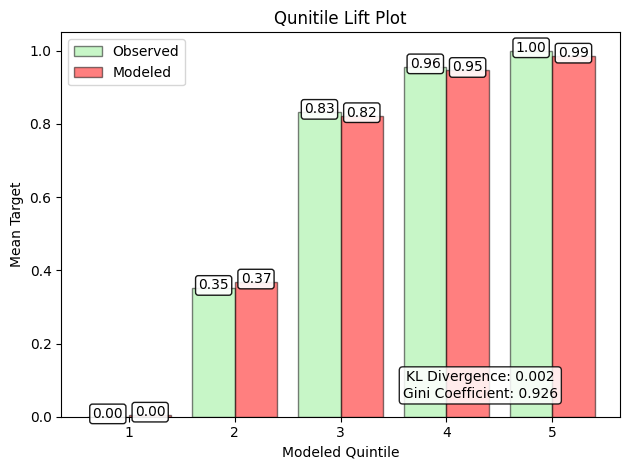

In [18]:
from predictables.univariate.src.plots._quintile_lift_plot import quintile_lift_plot

fig, ax = plt.subplots()
ax = quintile_lift_plot(
    m.X_train.iloc[:, 0], m.y_train, m.yhat_train, backend="matplotlib", ax=ax
)
plt.show()

In [19]:
feature = m.X_train.iloc[:, 0]
target = m.y_train
feature_name = "comp_1"
target_name = "target"

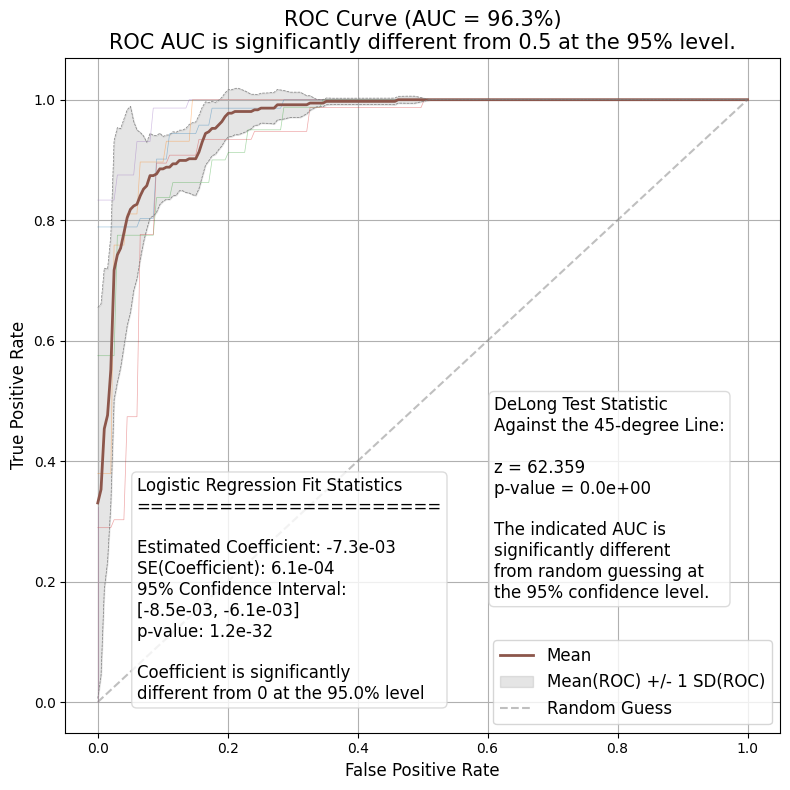

In [20]:
from predictables.univariate.src.plots._roc_curve_plot import roc_curve_plot

roc_curve_plot(
    m.y_train,
    m.yhat_train,
    m.df.cv,
    coef=m.coef,
    se=m.se,
    pvalue=m.pvalues,
);

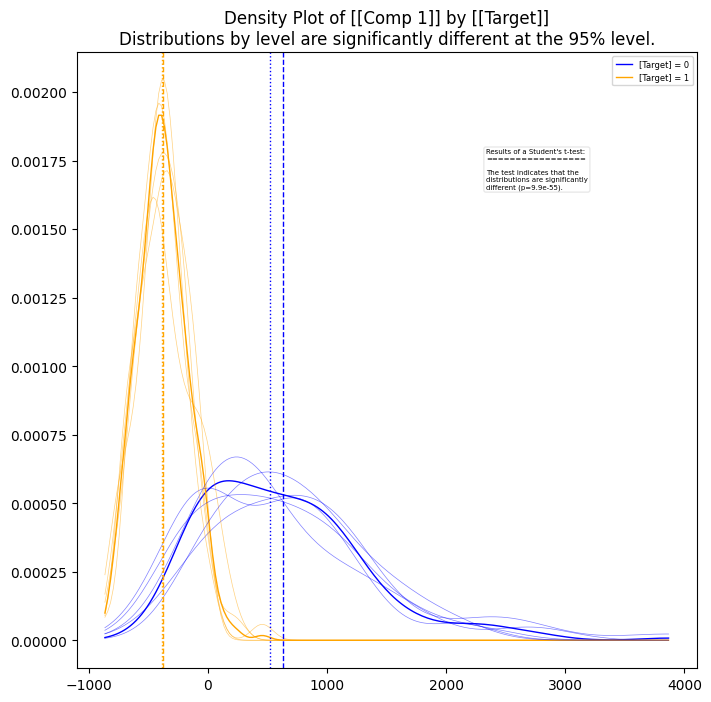

In [21]:
from predictables.univariate.src.plots._density_plot import density_plot

ax = density_plot(feature, m.y_train, m.df.cv)
plt.show()

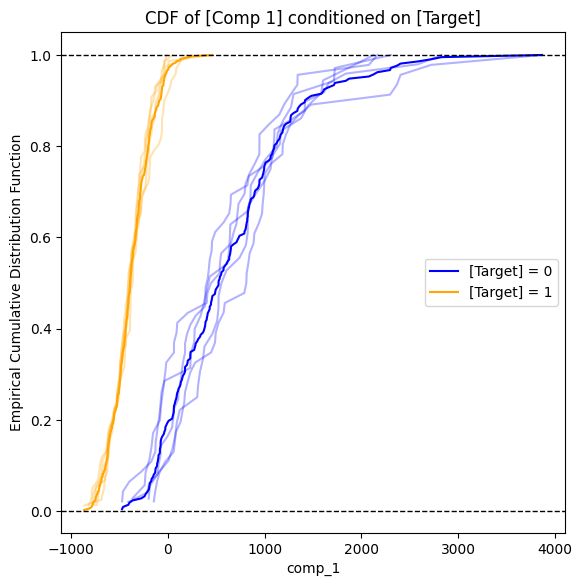

In [22]:
from predictables.univariate.src.plots._cdf_plot import cdf_plot

cdf_plot(feature, m.y_train, m.df.cv, figsize=(6.5, 6.5));

In [24]:
from predictables.util.report import Report

In [25]:
m.df.head()

,comp_1,comp_2,cv,target
0,1160.142186,-293.918296,5,0
1,1269.122238,15.629752,4,0
2,995.793505,39.155983,5,0
3,-407.180613,-67.379945,2,0
4,930.341164,189.340669,3,0


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from predictables.univariate import Univariate
df = pd.read_parquet("./cancerdf.parquet")
ua = Univariate(
    df, "cv", "comp_1", "target"
)
ua.results.round(4).T

fold,1,2,3,4,5,mean,std
coef,-0.0069,-0.0074,-0.0080,-0.0071,-0.0072,-0.0073,0.0004
pvalues,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
se,0.0006,0.0007,0.0008,0.0007,0.0007,0.0006,0.0001
lower_ci,-0.0081,-0.0088,-0.0095,-0.0084,-0.0085,-0.0085,0.0005
upper_ci,-0.0056,-0.0060,-0.0065,-0.0058,-0.0059,-0.0061,0.0003
acc_train,0.8937,0.9097,0.9217,0.9026,0.9071,0.9069,0.0102
acc_test,0.9630,0.8957,0.8525,0.9252,0.9060,0.9069,0.0405
auc_train,0.8727,0.8944,0.9057,0.8787,0.8811,0.8865,0.0133
auc_test,0.9514,0.8446,0.8172,0.9184,0.9034,0.8865,0.0549
f1_train,0.9179,0.9287,0.9396,0.9273,0.9302,0.9287,0.0077


In [12]:
ua.get_data('x', 'train')

0      1160.142186
1      1269.122238
2       995.793505
3      -407.180613
4       930.341164
          ...     
564    1414.126842
565    1045.018653
566     314.501383
567    1124.858095
568    -771.527427
Name: comp_1, Length: 569, dtype: float64

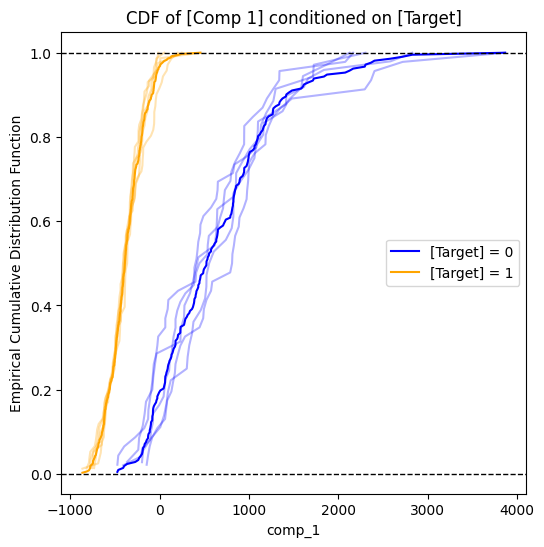

In [13]:
ua.plot_cdf();

In [8]:
dir(ua)

['X',
 'X_test',
 'X_train',
 'Y',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_folds',
 'acc_test',
 'acc_train',
 'aic',
 'auc_test',
 'auc_train',
 'coef',
 'cv',
 'df',
 'df_all',
 'df_val',
 'f1_test',
 'f1_train',
 'feature',
 'feature_col',
 'feature_name',
 'figsize',
 'fold',
 'fold_col',
 'folds',
 'get_data',
 'is_binary',
 'k',
 'logloss_test',
 'logloss_train',
 'lower_ci',
 'mcc_test',
 'mcc_train',
 'model',
 'n',
 'plot_cdf',
 'pr_curve_test',
 'pr_curve_train',
 'precision_test',
 'precision_train',
 'pvalues',
 'recall_test',
 'recall_train',
 'results',
 'roc_curve_test',
 'roc_curve_train',
 'se',
 'sk_coef',
 'sk_model',
 'target',
 'targe

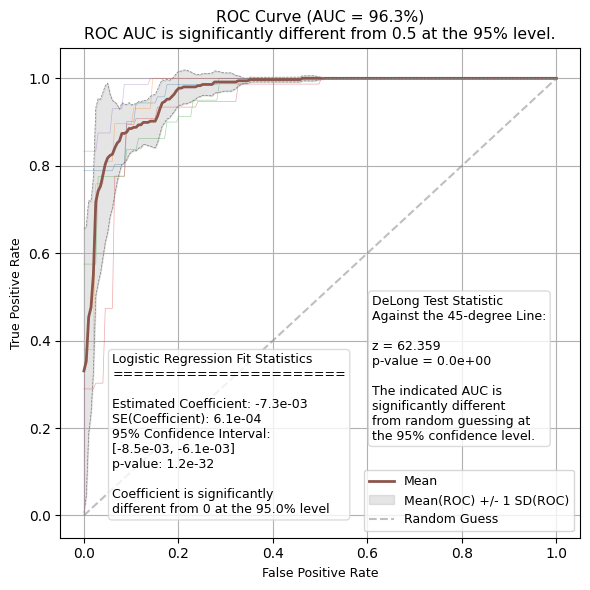

In [18]:
from predictables.univariate.src.plots import roc_curve_plot
fig, ax = plt.subplots(figsize=(6,6))
roc_curve_plot(ua.y, ua.yhat_train, ua.cv, ua.coef, ua.se, ua.pvalues, ax=ax, figsize=fig.get_size_inches());
